In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

try:
    os.chdir(os.path.join(os.getcwd(), '../../catchgame/'))
except:
    print("already in directory")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda is available


In [2]:
from modules.dqn.network import QNetworkConv
from world import CatchEnv

n_actions = 3
n_episodes = 1000
batch_size = 512

CATCH_ENV_NUM_STATES = 4
CATCH_ENV_WORLD_SIZE = (84, 84)
CATCH_ENV_POSSIBLE_ACTIONS = [0, 1, 2]

spatial_size = CATCH_ENV_WORLD_SIZE

dqn = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES, 
    spatial_size=spatial_size, 
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)
dqn_target = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES,
    spatial_size=spatial_size,
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)

In [3]:
env = CatchEnv()
env.reset_random()
next_state, reward, done = env.step(action=1)
next_state.shape, reward, done

((84, 84, 4), 0, False)

In [4]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(spatial_size),
    lambda x: x.unsqueeze(0),
    lambda x: x.type(torch.float32),
])

transforms(next_state).shape

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 4, 84, 84])

In [5]:
optimizer = optim.Adam(dqn.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

num_episodes = 1000
epsilon = 0.8
gamma = 0.9
epsilon_decay = 0.99


In [6]:
experiment_log = []
def log(data: dict):
    experiment_log.append(data)
    print("; ".join([f"{k}: {v}" for k, v in data.items()]))

In [7]:
import random
from collections import deque

# Define a replay buffer class to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, done_flags = zip(*batch)
        return states, actions, rewards, next_states, done_flags

# Initialize the replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

def evaulate(epsilon=0.0, num_episodes=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset_random()
        state = transforms(state)
        done = False
        episode_reward = 0
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
            else:
                q_values = dqn(state.to(device))
                action = q_values.argmax().item()
            next_state, reward, done = env.step(action)
            next_state = transforms(next_state)
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)
    return np.mean(rewards)

def sample_epsilon_exponential_decay(min_epsilon=0.01, max_epsilon=0.9, t=0.0, decay_rate=0.5):
    I = max_epsilon
    E = min_epsilon
    s = 10 * decay_rate
    theta = (np.exp(-s*t) -1) / (1 - np.exp(-s)) + 1
    return (I - E) * theta + E

# Define the main training loop
best_performance = evaulate(epsilon=0.0, num_episodes=10)
log({"episode": 0, "epsilon": 0.0, "reward": best_performance})

for episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.reset_random()
    state = transforms(state)
    done = False
    
    done_i = 0

    while not done:
        # Choose an action using an epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
        else:
            q_values = dqn(state.to(device))
            action = q_values.argmax().item()
        
        # Take the action and observe the next state and reward
        next_state, reward, done = env.step(action)
        next_state = transforms(next_state)
        
        # Add the experience to the replay buffer
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Sample a batch of experiences from the replay buffer
        if len(replay_buffer.buffer) > batch_size:
            states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
            # (batch, 4, 84, 84)
            # [(1, 4, 84, 84), ... ] -> (batch, 4, 84, 84)
            
            states = torch.cat(states).to(device)
            actions = torch.Tensor(actions).type(dtype=torch.int64).to(device)
            rewards = torch.Tensor(rewards).to(device)
            next_states = torch.cat(next_states).to(device)
            done_flags = torch.Tensor(done_flags).to(device)

            # Compute the target Q-values using the DDQN algorithm
            q_values = dqn(states)
            max_actions = q_values.argmax(dim=-1)
            
            with torch.no_grad():
                q_values_target = dqn_target(next_states)
            q_values_target = q_values_target.gather(1, max_actions.unsqueeze(-1)).squeeze(-1)
            q_values_target = rewards + gamma * q_values_target * (1 - done_flags)
            
            # Compute the current Q-values and the loss
            current_q_values = q_values.gather(1, torch.Tensor(actions).unsqueeze(-1)).squeeze(-1)
            loss = criterion(current_q_values, q_values_target.detach())
            
            # Update the DQN network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the target network
            if done_i % 10 == 0:
                dqn_target.load_state_dict(dqn.state_dict())
            done_i += 1
        
        # Update the state
        state = next_state

    # Evaluate the policy and save the results
    if episode % 10 == 0:
        mean_reward = evaulate(epsilon=0.0, num_episodes=10)
        epsilon = sample_epsilon_exponential_decay(t=mean_reward, decay_rate=0.8)
        if mean_reward > best_performance:
            best_performance = mean_reward
            torch.save(dqn.state_dict(), "models/dqn_best.pt")
        log({"episode": episode, "mean_reward": mean_reward, "epsilon": epsilon})
      

episode: 0; epsilon: 0.0; reward: 0.4


  0%|          | 1/1000 [00:00<02:26,  6.80it/s]

episode: 0; mean_reward: 0.1; epsilon: 0.4097383135906444


  2%|▏         | 16/1000 [00:00<00:27, 35.84it/s]

episode: 10; mean_reward: 0.1; epsilon: 0.4097383135906444


  2%|▏         | 21/1000 [00:00<00:30, 31.60it/s]

episode: 20; mean_reward: 0.1; epsilon: 0.4097383135906444


  4%|▍         | 39/1000 [00:01<00:21, 44.45it/s]

episode: 30; mean_reward: 0.3; epsilon: 0.0904674104977299


  4%|▍         | 45/1000 [00:01<00:25, 37.22it/s]

episode: 40; mean_reward: 0.2; epsilon: 0.18944953788996655


  5%|▌         | 50/1000 [00:03<02:01,  7.83it/s]

episode: 50; mean_reward: 0.2; epsilon: 0.18944953788996655


  6%|▌         | 61/1000 [00:10<06:54,  2.27it/s]

episode: 60; mean_reward: 0.0; epsilon: 0.9


  7%|▋         | 71/1000 [00:15<08:40,  1.79it/s]

episode: 70; mean_reward: 0.4; epsilon: 0.04599187373045737


  8%|▊         | 81/1000 [00:22<10:22,  1.48it/s]

episode: 80; mean_reward: 0.2; epsilon: 0.18944953788996655


  9%|▉         | 91/1000 [00:28<09:59,  1.52it/s]

episode: 90; mean_reward: 0.3; epsilon: 0.0904674104977299


 10%|█         | 101/1000 [00:35<10:17,  1.46it/s]

episode: 100; mean_reward: 0.4; epsilon: 0.04599187373045737


 11%|█         | 111/1000 [00:41<10:00,  1.48it/s]

episode: 110; mean_reward: 0.6; epsilon: 0.017028270857005926


 12%|█▏        | 121/1000 [00:47<09:52,  1.48it/s]

episode: 120; mean_reward: 0.5; epsilon: 0.02600772686626148


 13%|█▎        | 131/1000 [00:54<09:56,  1.46it/s]

episode: 130; mean_reward: 0.6; epsilon: 0.017028270857005926


 14%|█▍        | 141/1000 [01:00<09:49,  1.46it/s]

episode: 140; mean_reward: 0.1; epsilon: 0.4097383135906444


 15%|█▌        | 151/1000 [01:07<09:06,  1.55it/s]

episode: 150; mean_reward: 0.2; epsilon: 0.18944953788996655


 16%|█▌        | 161/1000 [01:13<09:16,  1.51it/s]

episode: 160; mean_reward: 0.3; epsilon: 0.0904674104977299


 17%|█▋        | 171/1000 [01:19<09:14,  1.49it/s]

episode: 170; mean_reward: 0.4; epsilon: 0.04599187373045737


 18%|█▊        | 181/1000 [01:26<09:16,  1.47it/s]

episode: 180; mean_reward: 0.4; epsilon: 0.04599187373045737


 19%|█▉        | 191/1000 [01:32<09:08,  1.47it/s]

episode: 190; mean_reward: 0.5; epsilon: 0.02600772686626148


 20%|██        | 201/1000 [01:39<09:08,  1.46it/s]

episode: 200; mean_reward: 0.7; epsilon: 0.01299354119003091


 21%|██        | 211/1000 [01:45<08:56,  1.47it/s]

episode: 210; mean_reward: 0.4; epsilon: 0.04599187373045737


 22%|██▏       | 221/1000 [01:51<07:31,  1.72it/s]

episode: 220; mean_reward: 0.6; epsilon: 0.017028270857005926


 23%|██▎       | 231/1000 [01:56<07:23,  1.74it/s]

episode: 230; mean_reward: 0.4; epsilon: 0.04599187373045737


 24%|██▍       | 241/1000 [02:02<07:13,  1.75it/s]

episode: 240; mean_reward: 0.7; epsilon: 0.01299354119003091


 25%|██▌       | 251/1000 [02:07<07:18,  1.71it/s]

episode: 250; mean_reward: 0.5; epsilon: 0.02600772686626148


 26%|██▌       | 261/1000 [02:13<07:20,  1.68it/s]

episode: 260; mean_reward: 0.3; epsilon: 0.0904674104977299


 27%|██▋       | 271/1000 [02:19<07:10,  1.69it/s]

episode: 270; mean_reward: 0.4; epsilon: 0.04599187373045737


 28%|██▊       | 281/1000 [02:24<07:05,  1.69it/s]

episode: 280; mean_reward: 0.4; epsilon: 0.04599187373045737


 29%|██▉       | 291/1000 [02:30<07:15,  1.63it/s]

episode: 290; mean_reward: 0.5; epsilon: 0.02600772686626148


 30%|███       | 301/1000 [02:36<07:00,  1.66it/s]

episode: 300; mean_reward: 0.7; epsilon: 0.01299354119003091


 31%|███       | 311/1000 [02:42<06:58,  1.65it/s]

episode: 310; mean_reward: 0.9; epsilon: 0.01036602241746411


 32%|███▏      | 321/1000 [02:47<06:52,  1.65it/s]

episode: 320; mean_reward: 0.5; epsilon: 0.02600772686626148


 33%|███▎      | 331/1000 [02:53<06:53,  1.62it/s]

episode: 330; mean_reward: 0.2; epsilon: 0.18944953788996655


 34%|███▍      | 341/1000 [02:59<06:29,  1.69it/s]

episode: 340; mean_reward: 0.6; epsilon: 0.017028270857005926


 35%|███▌      | 351/1000 [03:05<06:59,  1.55it/s]

episode: 350; mean_reward: 0.6; epsilon: 0.017028270857005926


 36%|███▌      | 361/1000 [03:11<07:07,  1.50it/s]

episode: 360; mean_reward: 1.0; epsilon: 0.01


 37%|███▋      | 371/1000 [03:18<07:12,  1.46it/s]

episode: 370; mean_reward: 0.6; epsilon: 0.017028270857005926


 38%|███▊      | 381/1000 [03:24<06:57,  1.48it/s]

episode: 380; mean_reward: 0.6; epsilon: 0.017028270857005926


 39%|███▉      | 390/1000 [03:30<06:22,  1.59it/s]

In [ ]:
# save experiment log where each key is a numpy array
from datetime import datetime
import pandas as pd

runs_folder = "./runs"
run_name = "run-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
os.makedirs(runs_folder, exist_ok=True)
os.makedirs(os.path.join(runs_folder, run_name), exist_ok=True)
keys = experiment_log[0].keys()
for key in keys:
    np.save(os.path.join(runs_folder, run_name, f"{key}.npy"), np.array([log.get(key, None) for log in experiment_log]))

df = pd.DataFrame(experiment_log)
df.to_csv(os.path.join(runs_folder, run_name, "log.csv"), index=False)

In [ ]:
# load and plot all keys into a single plot
import matplotlib.pyplot as plt
keys = ["mean_reward", "epsilon"]

In [ ]:
# load best 
dqn.load_state_dict(torch.load("models/dqn_best.pt"))

<All keys matched successfully>

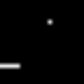

In [ ]:
# evluation
env = CatchEnv()
state = env.reset_random()
state = transforms(state)
video = []

while True:
    q_values = dqn(state.to(device))
    action = q_values.argmax().item()
    next_state, reward, done = env.step(action)
    next_state = transforms(next_state)
    state = next_state
    video.append(next_state.squeeze(0))
    if done:
        break

frames = []
video = torch.stack(video)
# shape (k iterations, 4 frames, 84, 84)
# put side to side resulting in (4 * k, 84, 84) without changing the order
video = video.permute(1, 0, 2, 3).reshape(4 * len(video), 84, 84)

# video is of shape (time, 84, 84)
# make a gif and display it
import imageio
from IPython.display import Image

imageio.mimsave("dqn_conv.gif", 255 * video.cpu().numpy())
Image(filename="dqn_conv.gif", format='png')